# Convolutional ANN and Transfer learning – D7046E @ LTU.SE

# Introduction
The goal of this exercise is for you to get a better understanding of what convolution is, how it is leveraged to increase the usability and performance of neural networks. The exercise will also teach you about transfer learning and the differences between fine tuning/feature extraction. 

## Literature
This exercise will rely on the following sections in the [course book](https://www.deeplearningbook.org/).

- Chapter 9
    - Most of it
- Chapter 7
    - Section 7.4 - Dataset augmentation
- Chapter 15
    - Section 15.2 - Transfer learning
    
## Examination
Epochs are predefined to be 100, if this is taking too long on your pc you can decrease it. Just make sure that you use the same hyperparameter values on task 2, 3 and 4. **Make sure you have all examination requirements in order before presenting.**

### Task 1
1. Implementation of "same convolution".
2. Compute and illustrate the resulting image using 3 different convolution filters.

### Task 2
1. Implement a CNN defined, trained and validated on the given dataset. Don't forget to make the train/validation split of the dataset. This can be achieved programatically using https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Implement a data augmentation technique that fits well with the data. Does this increase or decrease the validation accuracy?

### Task 3
1. Fine-tune a pre-trained model on the dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

### Task 4
1. Use a pre-trained model as a feature extractor on the dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

In [1]:
%matplotlib inline
from torch.utils.data import TensorDataset, DataLoader,random_split 
import torch
from torch import nn
import os
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

# Convolution in Neural Networks
A convolutional neural network, CNN for short, is a type of ANN which consists of at least one convolutional layer. CNNs are often used where the input size may vary such as when we are dealing with image input. The arcitecture of CNNs were inspired by how the visual cortex functions in our brain.

## Task 1: Implement convolution
Implement 2d same convolution without using a built in convolution function. This should function as described in [this blogpost](https://jcbgamboa.github.io/2017/08/12/what-are-convolutions/). One of the great strengths of convolution is that it functions on any sized image, hence it is important that your implementation also does. Same convolution basically means that the dimensions of the output is the same as the dimensions of the input. This is achieved by padding the input.

Once you have implemented a function which performs 2d convolution, use that to perform convolution over all channels in this image. Show the result using 3 different filters.

To find the padding needed to get the input to be the same space as the output you can use the formula:

$$ n_{out} = \left \lfloor\frac{n_{in}+2p-k}{s} \right \rfloor+1 $$

where $n_{out}$ is the number of output features, $n_{in}$ is the number of input features, $k$ is the kernel size, $p$ is the padding size and $s$ is the stride size. You are allowed to define that the stride is always 1.

In [2]:
epochs = 100

[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Gaussian blur')

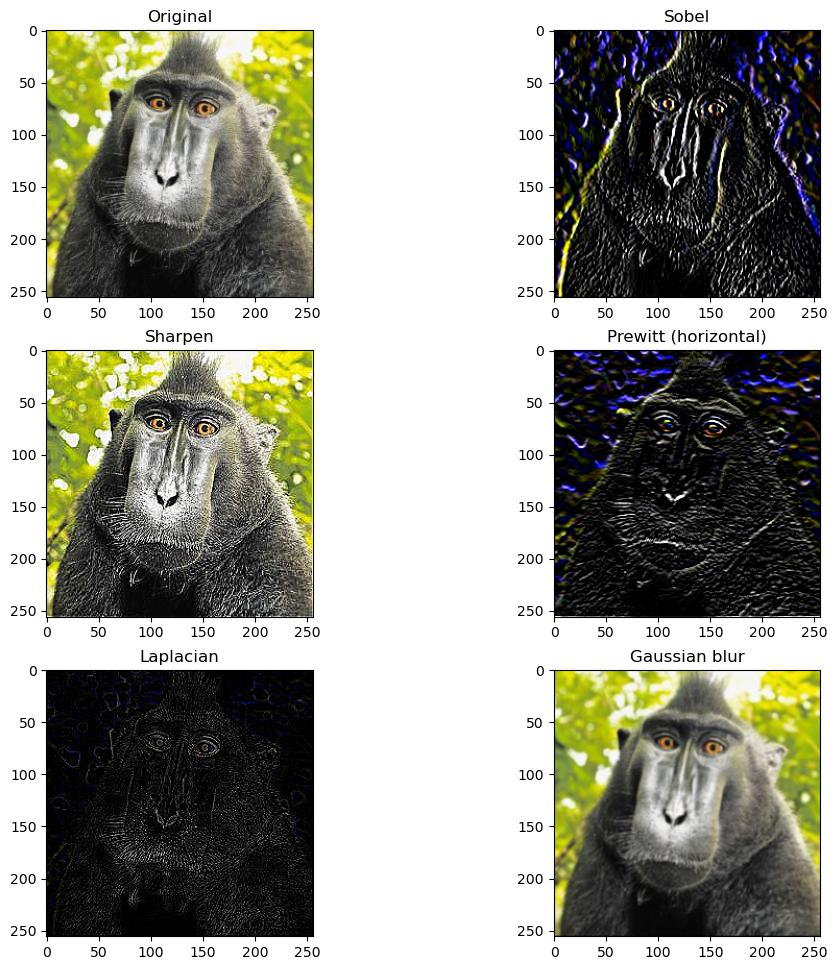

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100



# implement same convolution
def conv(image, kernel, strides=1):
    # flip kernel (hori and vert)
    kernel_p = np.flip(kernel, 0)
    kernel_p = np.flip(kernel_p, 1)
    
    # Pad the input so that n_out = n_in
    padding_size = int((kernel_p.shape[1] - 1) / 2) # derived from the given function with n_out = n_in and s = 1
    image = np.pad(image, padding_size)
    
    img_rows, img_cols = image.shape[0], image.shape[1]
    kernel_rows, kernel_cols = kernel.shape
    
    # Determine the number of shifts right and down
    right_shifts = img_cols - kernel_cols
    down_shifts = img_rows - kernel_rows
    
    # Shift fully to right, then repeat for each row down (down shift)
    convs = np.empty([down_shifts + 1, right_shifts + 1], dtype=int)
    for i in range(down_shifts + 1):
        for j in range(right_shifts + 1):
            # get submatrix and multiply elements and sum the result
            sub_img = image[i:kernel_rows + i, j:kernel_cols + j]
            convs[i, j] = np.sum(sub_img * kernel_p)

    return convs

def conv_rgb(image, kernel, strides=1):
    result = np.empty(shape=image.shape, dtype=int)
    for chan in range(3):
        result[:, :, chan] = conv(image[:, :, chan], kernel, strides)
    return result

# test
inp = np.array([[1,1,1,1],[1,1,2,1],[1,-3,-4,1],[1,1,1,1]])
kernel = np.array([[0,1,0],[1,2,1],[0,1,0]])
kernel_sobel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
kernel_corner = np.array([[1,-2,1],[-2,4,-2],[1,-2,1]])
kernel_sharpen = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
kernel_prewitt = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
kernel_laplacian = np.array([[0,1,0],[1,-4,1],[0,1,0]])
kernel_gausblur = np.array([[1,2,1],[2,4,2],[1,2,1]]) * 1/16

# blog post matrices
#inp = np.array([[0,3,6,3],[3,6,3,6],[6,3,6,3],[3,6,3,0]])
#kernel = np.array([[0,3,0],[0,1,2],[4,0,0]])

# if all are TRUE the convolution is implemented correctly
ans = np.array([[4, 5, 6, 4], [5, 3, 3, 6], [1, -7, -7, 0], [4, 1, 0, 4]])
print(conv(inp, kernel) == ans)

img = cv2.imread("monkey.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(3, 2, figsize=(12,12), dpi=100)
axs[0, 0].imshow(img, cmap="gray")
axs[0, 0].set_title("Original")

f1_img = conv_rgb(img, kernel_sobel)
axs[0, 1].imshow(f1_img, cmap="gray")
axs[0, 1].set_title("Sobel")

f2_img = conv_rgb(img, kernel_sharpen)
axs[1, 0].imshow(f2_img, cmap="gray")
axs[1, 0].set_title("Sharpen")

f3_img = conv_rgb(img, kernel_prewitt)
axs[1, 1].imshow(f3_img, cmap="gray")
axs[1, 1].set_title("Prewitt (horizontal)")

f4_img = conv_rgb(img, kernel_laplacian)
axs[2, 0].imshow(f4_img, cmap="gray")
axs[2, 0].set_title("Laplacian")

f5_img = conv_rgb(img, kernel_gausblur)
axs[2, 1].imshow(f5_img, cmap="gray")
axs[2, 1].set_title("Gaussian blur")

# Computer Vision
Computer vision (CV) is a task within the computer science field which aim is to extract high level information from static images or video. Such high level information can be, but is not limited to:
* Object detection - Detect and classify objects within input images
* Anomaly detection - Detect anomalies in the input images
* Segmantic segmentation - Classify each and every pixel in the input image into different classes
* Object recognition - Classifying an entire image depending on what it contains

CV has been studied for multiple decades where early solutions used handwritten feature extractors to extract information from the input. However with the increase of computing power together with the rise of deep learning algorithms, the main method used to solve CV problems is convolutional neural networks.

In this exercise we will be taking a closer look at object recognition by utilizing transfer learning. The dataset we will use for this exercise can be downloaded on canvas. It is a subset of [this dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). Remember to split the data into seperate training, validation and test set.

## Task 2: Implement a CNN and train it on the given dataset.

In [4]:
img_dim = (256, 256)

def load_images():
    ant_images = []
    anchor_images = []
    ant_path = "101_ObjectCategories_2classes/ant"
    anchor_path = "101_ObjectCategories_2classes/anchor"
    for image in os.listdir(ant_path):
        img = cv2.imread(os.path.join(ant_path, image))
        img = cv2.resize(img, dsize=img_dim)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            ant_images.append(img)
            
    for image in os.listdir(anchor_path):
        img = cv2.imread(os.path.join(anchor_path, image))
        img = cv2.resize(img, dsize=img_dim)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            anchor_images.append(img)
            
    return (ant_images, anchor_images)

def plot_image(img,label=None):
    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap="gray" )
    ax.set_title("ant"if label == 0 else "anchor")

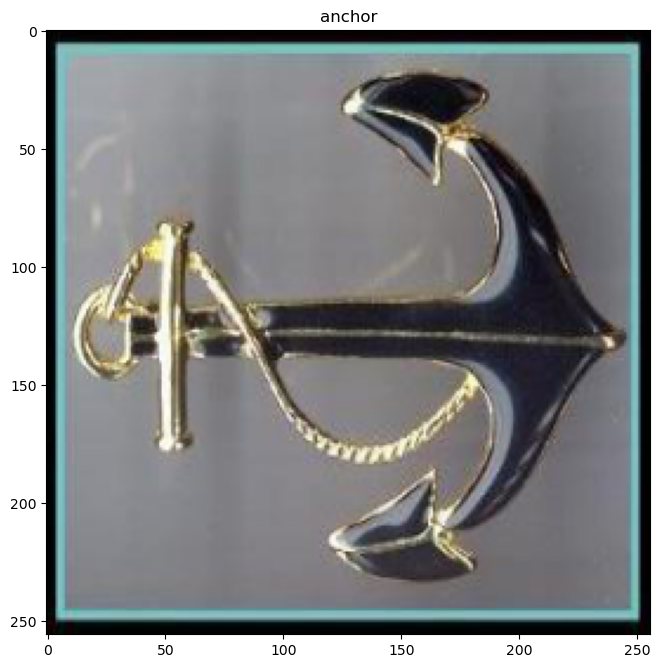

In [5]:
classes = {"ant": 0, "anchor": 1}

ant_images, anchor_images = load_images()

# Generate labels
ant_labels = [classes["ant"] for x in ant_images]
anchor_labels = [classes["anchor"] for x in anchor_images]

# Create TensorDataset
data = ant_images + anchor_images
data_tensor = torch.from_numpy(np.array(data)).type(torch.ByteTensor)
labels = ant_labels + anchor_labels
labels_tensor = torch.from_numpy(np.array(labels)).type(torch.LongTensor)
dataset = TensorDataset(data_tensor, labels_tensor)

# Split dataset
validation_data, train_data =random_split(dataset, [20, 64], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_data, batch_size=8, shuffle=False)
validation_loader = DataLoader(validation_data, batch_size = len(validation_data), shuffle=False)

# example image
plot_image(train_data[2][0], train_data[2][1])

In [6]:
# Implement your own CNN and train it on the given dataset
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layer with square kernel (4x4)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=4, groups=1, padding=0, dilation=1)
    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU(x)
        #h_relu = nn.ReLU(self.conv1(x))
        return x

In [7]:
network = CNN()

for epoch in range(epochs):
    for batch_nr, (data, labels) in enumerate(train_loader):
        print(data.shape)
        # reshape data inte (batch, chan, height, width)
        data = np.transpose(data, (0, 3, 1, 2)).type(torch.ByteTensor)
        print(data.shape)
        print(data.dtype)
        prediction = network(data)
        break
    break

torch.Size([8, 256, 256, 3])
torch.Size([8, 3, 256, 256])
torch.uint8


RuntimeError: expected scalar type Byte but found Float

# Transfer learning
Transfer learning refers to the practice to use a model which has already been pretrained on a large dataset to be able to solve task $T_1$, replace the output layer or a few of the upper layers within this model and retrain the model on a smaller dataset to be able to solve task $T_2$. Formally this can be described as the following:

__Def 1:__ Let $D_s$ be the source domain and $T_s$ be the corresponding source task. Let $D_t$ be the target domain and $T_t$ be the corresponding target task. Let $f_t$ be the predictive function for $T_s$. Thus transfer learning aims to improve the learning of $f_t$ in $D_t$ using the already learned knowledge in $D_s$ and $T_s$ where $D_s \neq D_t$ and $T_s \neq T_t$.

The benefit from using transfer learning is that we can train an accurate computer vision model with relatively small amounts of data and computing resources compared to the costly pretraining process of the full convolutional neural network (a few days using multiple gpus). 

## Fine-tuning and Feature extraction
There are two main ideas when it comes to transfer learning, fine-tuning and feature extraction. When using fine-tuning we allow all weights to be changed during the training phase. However when we use the pretrained model as a feature extractor we instead freeze earlier layers of the model, which means that the weights in those layers will not be updated during the training phase and we only update the weights in the upper layers that we have replaced. 

This works because low level information extracted from the input image is universal between tasks, examples of such information is edge detection, shape detection and pattern detection. This is what the early layers are optimized to do, as where later layers extract more abstract features relevant for the task. 

Most of the pre-trained models in pytorch are trained on [ImageNet](http://www.image-net.org/). 

## Task 3: Fine-tuning

In [ ]:
# Fine-tune a model to the dataset

## Task 4: Feature extraction

In [ ]:
# Use a predefined model as a feature extractor